# Exploring dataset


In this code the database from Quian Quiroga is used for studying the effect of the noise in 
the performance of different spike sorting algorithms with just different dimmensionality reduction techniques.

The code uses the functions developed by Viktor Arseni


In [1]:
# importing libraries
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
#from busz_funcs import pk, pts_extraction, butter_bandpass_filter_zi, load_kachery
#from toposort.preprocessing import spike_denoiser as denoiser, spike_aligner as aligner
import umap
import hdbscan
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA 
#from quiroga import *
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import random
#import umap.plot
import pywt
from scipy import stats
import pickle as pkl        # probably Vik needs to install this library, 
import SpkSort as s
from os import path as p
#plt.style.use('fivethirtyeight')
plt.rcParams['svg.fonttype'] = 'none'     # Export svg text as text and not paths!
print("done")

/home/sparra/anaconda3/envs/py11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done


In [13]:
from constants import *
for type_i in files.keys():
    for namefiles_i in files[type_i]:
        name=p.join(path, namefiles_i[0])
        spikes_n, labels_n, spike_times_n=s.load_quiroga_spikes(name, sample_points=64, remove_noise=False)
        cl_n, ncl_n=np.unique(labels_n, return_counts=True)
        
        print("%s: number of units: n"%(namefiles_i[0]), len(np.unique(labels_n)))


C_Easy1_noise01.mat: number of units: n 3
C_Easy1_noise02.mat: number of units: n 3
C_Easy1_noise03.mat: number of units: n 3
C_Easy1_noise04.mat: number of units: n 3
C_Easy1_noise005.mat: number of units: n 3
C_Easy1_noise015.mat: number of units: n 3
C_Easy1_noise025.mat: number of units: n 3
C_Easy1_noise035.mat: number of units: n 3
C_Difficult1_noise01.mat: number of units: n 3
C_Difficult1_noise02.mat: number of units: n 3
C_Difficult1_noise005.mat: number of units: n 3
C_Difficult1_noise015.mat: number of units: n 3
C_Difficult2_noise01.mat: number of units: n 3
C_Difficult2_noise02.mat: number of units: n 3
C_Difficult2_noise005.mat: number of units: n 3
C_Difficult2_noise015.mat: number of units: n 3
C_Burst_Easy2_noise015.mat: number of units: n 3
C_Drift_Easy2_noise015.mat: number of units: n 3


In [2]:
# What it means to have noise ?
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
namefiles= ("C_Easy1_noise01.mat", 
            "C_Easy1_noise02.mat", 
            "C_Easy1_noise03.mat",
            "C_Easy1_noise04.mat", 
            "C_Easy1_noise005.mat", 
            "C_Easy1_noise015.mat",
            "C_Easy1_noise025.mat",
            "C_Easy1_noise035.mat")
name=p.join(path, namefiles[0])
spikes,   labels, spike_times=s.load_quiroga_spikes(name, sample_points=64, remove_noise=True)
spikes_n, labels_n, spike_times_n=s.load_quiroga_spikes(name, sample_points=64, remove_noise=False)
data=loadmat(name)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'spike_class', 'spike_times', 'OVERLAP_DATA', 'data', 'chan', 'startData', 'samplingInterval'])


spikes: c, n (2753, 64) (3522, 64)
labels: c, n (2753,) (3522,)
spikes_times: c, n (2753,) (3522,)
number of units: c, n 3 3 [1 2 3]
Number of spikes per units no noise:  [1 2 3] [903 870 980]
Number of spikes per units with noise:  [1 2 3] [1151 1134 1237]


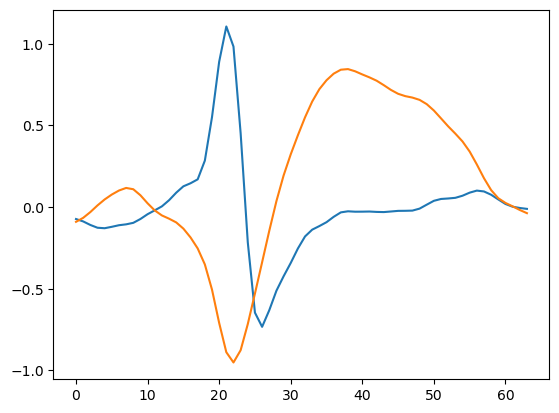

In [3]:
print("spikes: c, n", spikes.shape, spikes_n.shape)
print("labels: c, n", labels.shape, labels_n.shape)
print("spikes_times: c, n", spike_times.shape, spike_times_n.shape)
cl, ncl=np.unique(labels, return_counts=True)
cl_n, ncl_n=np.unique(labels_n, return_counts=True)

print("number of units: c, n", len(cl), len(np.unique(labels_n)), cl )
print("Number of spikes per units no noise: ", cl, ncl)
print("Number of spikes per units with noise: ", cl_n, ncl_n)

idx=4
plt.plot(spikes[idx])
plt.plot(spikes_n[idx])

**Do not remove noise or the comparison lost sense**

On the other hand, how is the firing rate of the spikes, it is constant during the measurement?, how much it is?.



In [4]:
print("shape data: ", data["data"].shape)
print("sampling: ", data["samplingInterval"][0])
print("startdata: ", data["startData"])
print("spike_class",data["spike_class"].shape)
print("length and first values spike_times", len(data["spike_times"][0][0][0]), data["spike_times"][0][0][0][-10:])

spike_times_n.max()

shape data:  (1, 1440000)
sampling:  [0.04166667]
startdata:  [[0]]
spike_class (1, 3)
length and first values spike_times 3522 [1436186 1436450 1437290 1437814 1437821 1437965 1438449 1438660 1438690
 1439287]


1439287

0.04869565217391304
0.05560458958517211
0.055825242718446605


Text(0, 0.5, 'Frequency')

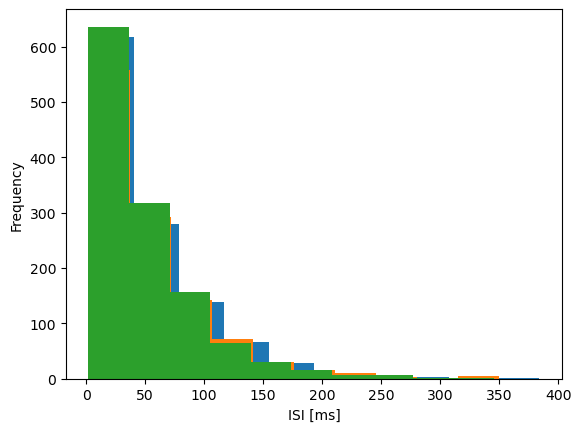

In [5]:
for neu_i in cl_n:
    mask=labels_n==neu_i
    isi=np.diff(spike_times_n[mask]*data["samplingInterval"][0])  # ms
    plt.hist(isi)
    print(np.sum(isi<5)/len(isi))
plt.xlabel("ISI [ms]")
plt.ylabel("Frequency")

## Firing rate in time

Rate for the neuron 1: 19.183 Hz
Rate for the neuron 2: 18.900 Hz
Rate for the neuron 3: 20.617 Hz


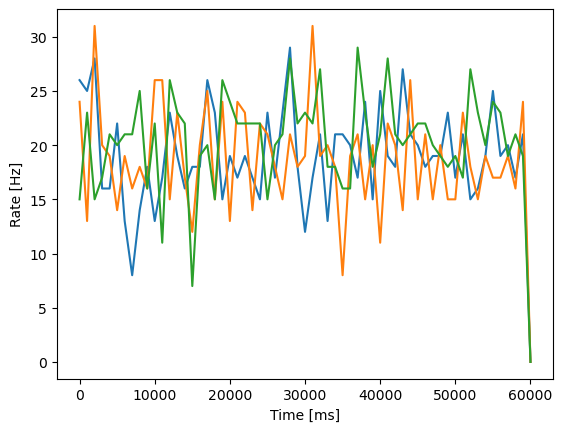

In [6]:
def tasa(spks, wnd, stp):
    t_end=spks[-1]
    t=np.arange(0, t_end + stp, stp)
    rate=np.zeros_like(t)
    for t_i in range(len(t)-1):
        rate[t_i]=np.sum(np.logical_and(spks>=t[t_i], spks<t[t_i+1]))        
    return rate, t

for neu_i in cl_n:
    mask=labels_n==neu_i
    neu=spike_times_n[mask]*data["samplingInterval"][0][0]
    rate, t=tasa(neu, 1500, 1000)
    plt.plot(t, rate, label="neu_%d"%(neu_i))
    plt.xlabel("Time [ms]")
    plt.ylabel("Rate [Hz]")
    # plt.legend(loc="best", frameon=False)
    print("Rate for the neuron %d: %.3f Hz"%(neu_i, len(neu)/(1440000*data["samplingInterval"][0][0]/1000)))

Every neuron probably has approximately the same rate. So, it's important to keep in mind that
in order to give to the reader a notion of differences is not enough to speak about the amount of dilution (ha no sense in real
scenario where rates can be so different). However, by indicating the variation in rate or the proportionality in the number of spikes.